# A predictive model for water pollution given changes in industry across counties in the United States


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
#import featuretools as ft
#import lightgbm as lgb
#import scikitplot as skplt
from sklearn.preprocessing import LabelEncoder

sns.set(rc={'figure.figsize':(20, 10)})

import os

### Authors

Brandon Wong <br>
Qiyue Zou <br>
Dajun Luo <br>
Zhe Wang 

## Non-Technical Executive Summary

# **Abstract** 

Water is an undeniable resource. It is essential for human wellbeing and is critical to various industry as well. However, as our economy grows and our industry develops, the by-products of expansion begin to accumulate. Access to safe water, even in a developed country such as the United States, is not guaranteed. Here using machine learning methods, we predict the quality of water in certain counties according to the distribution of industry types in those regions. Our model predictst that ...



With this in mind, we decided to explore how recent changes in industry affect water quality. ***after exploration we adjusted our purpose and decided to answer X question using Y predictive model***

Our finding can find its application in informing the at-risk population and ultimately produce a predictive model with the aim to mitigate water contamination. 

**findings here**

## Technical Exposition

**summary here** methodology/approach

### Team Toolset

Python: scikit-learn, pandas, Jupyter Notebook, Colaboratory<br>
Tableau, Excel, Box

### Data Understanding

***Explain why we used the datasets we used***

The following core datasets were pre-cleaned and provided by Citadel and CorrelationOne:
1.   *chemicals.csv*
2.   *droughts.csv*
3.   *earnings.csv*
4.   *educational_attainment.csv*
5.   *industry_occupation.csv*
6.   *water_usage.csv*

However, not all of them were relevent to our exploration. Since we wanted to study the relationship between changes in industry and water quality, we decided to use the *chemicals.csv* and *industry_occupation.csv* datasets. 



### Wrangling & Cleaning Process

Before performing any further analysis, we should first pre-process the datasets.

*chemicals.csv*

In [8]:
chemicals = pd.read_csv("chemicals.csv")
chemicals.head()

,cws_name,chemical_species,contaminant_level,county,pws_id,pop_served,state,unit_measurement,value,year,fips,state_fips
0,CALIFORNIA WATER SERVICE - LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110003,57200,California,micrograms/L,1.54,2000,6001,6
1,CITY OF LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110011,26400,California,micrograms/L,1.64,2000,6001,6
2,CITY OF PLEASANTON,Uranium,Less than or equal MCL,Alameda,CA0110008,70600,California,micrograms/L,1.64,2000,6001,6
3,DUBLIN SAN RAMON SERVICES DISTRICT,Uranium,Less than or equal MCL,Alameda,CA0110009,72500,California,micrograms/L,1.64,2000,6001,6
4,NORRIS CANYON PROPERTY OWNERS ASSN,Uranium,Less than or equal MCL,Alameda,CA0103040,100,California,micrograms/L,4.51,2000,6001,6


*industry_occupation.csv*

In [9]:
industry = pd.read_csv("industry_occupation.csv",encoding = "ISO-8859-1")
industry.head()

,geo_id,fips,county,total_employed,agriculture,construction,manufacturing,wholesale_trade,retail_trade,transport_utilities,information,finance_insurance_realestate,prof_scientific_waste,edu_health,arts_recreation,other,public_admin,year
0,0500000US01003,1003,"Baldwin County, Alabama",77263.0,1302.0,6489.0,6134.0,2131.0,9525.0,3557.0,940.0,5893.0,9873.0,14753.0,8257.0,3575.0,4834.0,2010
1,0500000US01015,1015,"Calhoun County, Alabama",42768.0,337.0,1371.0,7868.0,750.0,5706.0,1626.0,779.0,2234.0,3776.0,8351.0,3799.0,2440.0,3731.0,2010
2,0500000US01043,1043,"Cullman County, Alabama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
3,0500000US01049,1049,"DeKalb County, Alabama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,0500000US01051,1051,"Elmore County, Alabama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010


Checking if there extent of missing data,

In [10]:
print('There are %d NaNs in the chemical dataset' % sum(chemicals.isnull().sum()))
print('There are %d NaNs in the industry_occupation dataset' % sum(industry.isnull().sum()))

There are 0 NaNs in the chemical dataset
There are 10780 NaNs in the industry_occupation dataset


Although *chemical.csv* is complete, *industry_occupation.csv* is missing a substantial amount of data. So, we took a closer look at how the missing data in *industry_occupation.csv* was spread. 

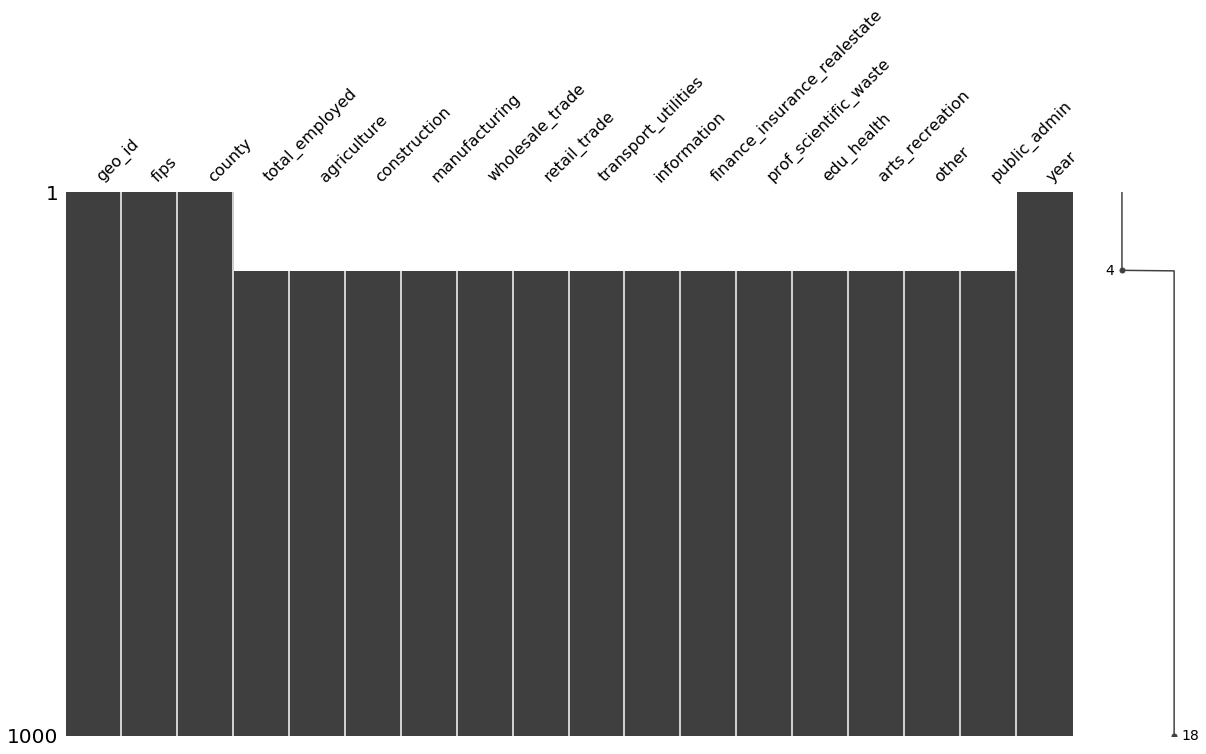

In [18]:
msno.matrix(industry.sample(1000), inline=True, sparkline=True, figsize=(20,10), sort='ascending')

We observe a pattern from the plot: A county either has complete data, or it has no data about its industry and occupation. From the pattern and to avoid unnecessary complexity, we assume that the missing data points are MCAR. As a result, we just drop the rows with missing values.

In [19]:
industry.dropna(inplace=True)
print('There are %d NaNs in the industry_occupation dataset' % sum(industry.isnull().sum()))

There are 0 NaNs in the industry_occupation dataset


Now, we should combine both datasets; the first step is alignment.

In [0]:
industry['state'] = industry['county'].map(lambda x: x.split(',')[1][1:])
industry['county'] = industry['county'].map(lambda x: x.split(',')[0].replace(' County', '')).tolist()

In [21]:
print('There are %d states in the chemical dataset\nThere are %d states in the industry_occupation dataset' % (len(set(chemicals['state'])), len(set(industry['state']))))

There are 27 states in the chemical dataset
There are 51 states in the industry_occupation dataset


Since the set of states represented in the two datasets are non-identical, further analysis can only be performed on its intersection. 

In [0]:
industry = industry[industry['state'].isin(set(chemicals['state']))]

### Exploratory Data Analysis

Data manipulation and exploration process.

Analytical and modeling steps

1.   What hypotheses tests and ad-hoc studies did you we perform?
2.   How were those results interpreted?
3.   What patterns did we notice?
4.   How did these patterns inform our subsequent decisions?


Now, we want to see how employment is distributed across the major industry sectors within each county. However, 
there are over a thousand counties and it is not feasible to analyse the distribution on a county by county basis. To overcome this, we aggregate the employment distribution across all counties. 

In [23]:
industry.columns

Index(['geo_id', 'fips', 'county', 'total_employed', 'agriculture',
       'construction', 'manufacturing', 'wholesale_trade', 'retail_trade',
       'transport_utilities', 'information', 'finance_insurance_realestate',
       'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other',
       'public_admin', 'year', 'state'],
      dtype='object')

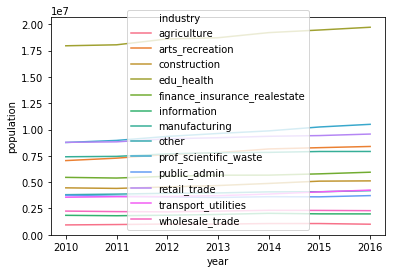

In [24]:
industry_cat = ['agriculture','construction', 'manufacturing', 'wholesale_trade', 'retail_trade','transport_utilities', 'information', 'finance_insurance_realestate','prof_scientific_waste', 'edu_health', 'arts_recreation', 'other','public_admin']
industry_long = pd.melt(industry, id_vars=['geo_id', 'year'], value_vars=industry_cat, var_name='industry', value_name='population')
industry_population = pd.pivot_table(industry_long, index='industry', columns='year', aggfunc='sum').astype('int')
industry_population = pd.melt(industry_population['population'].T.reset_index(), id_vars=['year'], value_name='population')
plot = sns.lineplot(x = 'year', y='population', hue='industry', data = industry_population)

From the graph above, we see that employment distribution is stable from 2010-2016. Henceforth, we will assume that future employment distribution will be similarly stable. 

Now, we will take a closer look at the *chemicals.csv* file. We want to see if the unit of measurement used is consistent over the years. 

1.   List item
2.   List item



In [25]:
# Show how many times for a unit measurement was used on a chemical species
pd.pivot_table(chemicals[['chemical_species', 'unit_measurement', 'value']], index='chemical_species', columns='unit_measurement', aggfunc='count').fillna(0).astype('int')

value             
unit_measurement micrograms/L milligrams/L
chemical_species                          
Arsenic                142001            0
DEHP                    72825            0
Halo-Acetic Acid       146132            0
Nitrates                    0       329372
Trihalomethane         154258            0
Uranium                 37731            0

We see that the unit of measurement is indeed consistent. 

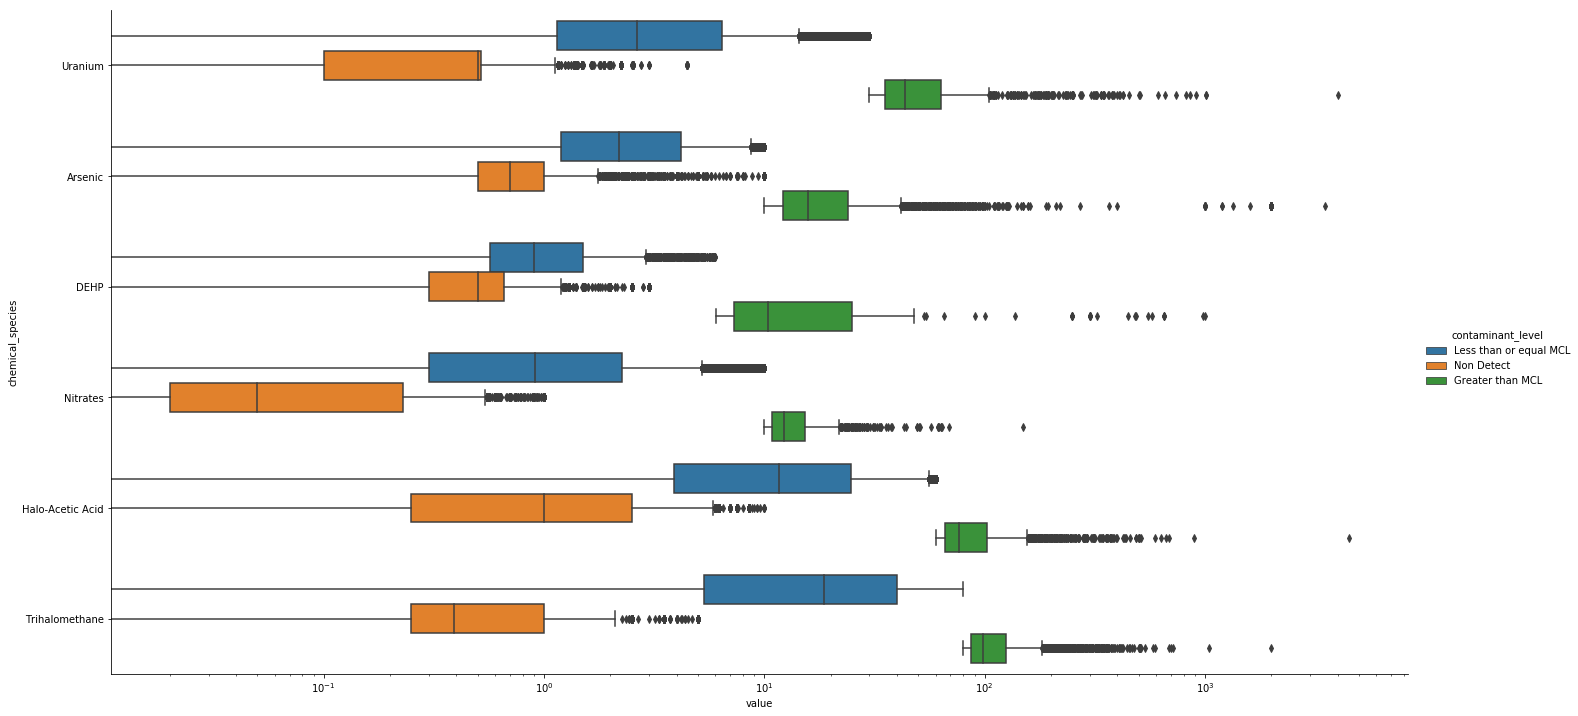

In [26]:
plot = sns.catplot(x="value", y="chemical_species", hue='contaminant_level',kind="box", height=10, aspect=2, data=chemicals)
plot.set_titles('Box plot of contaminant valye by chemical species')
ax = plot.axes[0][0]
ax.set_xscale('log')

Looking at the *containment_level* and *value* feature of the *chemicals.csv*, we see that different counties have different standards for each of the six chemicals. 

Because of this inconsistency, in future analysis, we will use the level instead of raw values. 

In [0]:
chem_indus = pd.merge(left=chemicals, right=industry, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner')

In [0]:
from collections import defaultdict
corr = defaultdict(list)
for chem_y in set(chem_indus['chemical_species']):
    for indus in industry_cat:
        temp_df = chem_indus[chem_indus['chemical_species'] == chem_y][['value', indus]]
        corr[chem_y].append(np.corrcoef(temp_df['value'], temp_df[indus])[0][1])

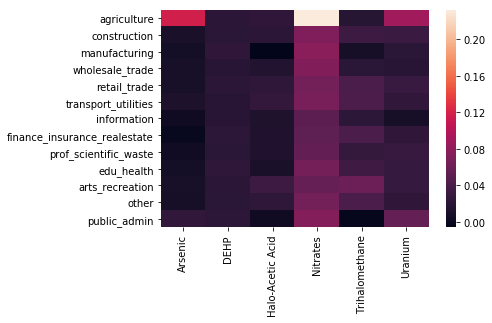

In [29]:
corr = pd.DataFrame(corr)
corr.index = industry_cat
sns.heatmap(corr)

The above heatmap shows the correlation between the different types of industires and the level of contamination for each of the six chemical species. We see that Nitrates are correlated with most industries, but especially with agriculture. 

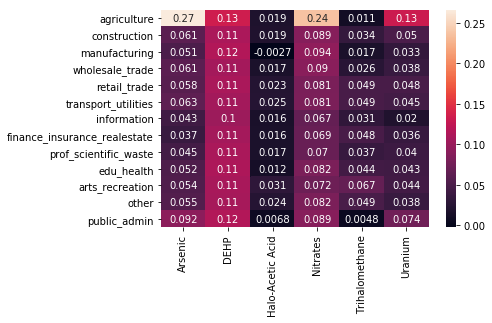

In [31]:
industry['lag_1'] = industry['year'] + 3
chem_indus = pd.merge(left=chemicals, right=industry, left_on=['year', 'state', 'county'], right_on=['lag_1', 'state', 'county'], how='inner')
corr = defaultdict(list)
for chem_y in set(chem_indus['chemical_species']):
    for indus in industry_cat:
        temp_df = chem_indus[chem_indus['chemical_species'] == chem_y][['value', indus]]
        corr[chem_y].append(np.corrcoef(temp_df['value'], temp_df[indus])[0][1])
corr = pd.DataFrame(corr)
corr.index = industry_cat
plot = sns.heatmap(corr, annot=True)

The above heatmap shows the correlation when timelag=2. This timelagged heatmap exhibited a greater correlation than the non-timelagged heatmap two figures above. So, henceforth we will use the timelag=2 heatmap. 

### Modeling

**Analysis:**

1.   What assumptions and choices did we make?
2.   Why did we make those assumptions and choices?
3.   How did we perform feature selection?

**Model:**

1.   What does it show?
2.   How did we analyse the model performance?
3.   What are the model's limitations and shortcomings?

**Visualisations and Statistical Tests**

1.   Why did we make these visualisations or statistical tests?
2.   What do they tell us?

Now, we will create the timelag=2 dataset to be used in our predictive model. 

In [0]:

chemicals = chemicals[['chemical_species', 'contaminant_level', 'county', 'pop_served', 'state', 'value', 'year']]
chemicals['danger'] = chemicals['contaminant_level'] == 'Greater than MCL'
chemicals.head()
industry = industry[['county', 'state', 'year'] + industry_cat]
for cat in industry_cat:
    industry['percentage_' + cat] = industry[cat] / industry[industry_cat].sum(axis=1)
lag_1 = industry.copy()
lag_2 = industry.copy()
lag_1['year'] = lag_1['year'] + 1
lag_2['year'] = lag_2['year'] + 2

We then perform a train test split and reclassify the *containment_level* feature. Originally, the levels were: 


1.   Less than
2.   Non-detect
3.   Greater than




In [0]:
data = pd.merge(left=chemicals, right=industry, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner')\
.merge(lag_1, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner', suffixes=['', '_lag1'])\
.merge(lag_2, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner', suffixes=['', '_lag2'])
data.head()
contaminant_encoder = LabelEncoder()
state_encoder = LabelEncoder()
county_encoder = LabelEncoder()
chemical_species_encoder = LabelEncoder()
data['chemical_species'] = contaminant_encoder.fit_transform(data['chemical_species'])
data['contaminant_level'] = contaminant_encoder.fit_transform(data['contaminant_level'])
data['state'] = state_encoder.fit_transform(data['state'])
data['county'] = county_encoder.fit_transform(data['county'])
label = data[['contaminant_level', 'value', 'danger', 'year']]
data = data.drop(['contaminant_level', 'value', 'danger'], axis=1)

We now have: 



1.   Safe (less than and non-detect)
2.   Danger (greater than)


Lets now see how *containment_level* is distibuted across counties.

In [41]:
print('Count of danger is %d, count of safe is %d' % (sum(label['danger']), label.shape[0] - sum(label['danger'])))

Count of danger is 1612, count of safe is 172907


Because the data is imbalanced, we will use AUC to measure the accuracy.


In [0]:
train, test = data[data['year'] < 2016], data[data['year'] >= 2016]
train_label, test_label = label[label['year'] < 2016], label[label['year'] >= 2016]

We chose LightGBM as our prediction model because it is generally faster and has higher accuracy. LightGBM is a gradient boosting framework that uses tree based learning algorithm. LightGBM grows tree vertically while other algorithm grows trees horizontally meaning that LightGBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

In [44]:
lgb_train = lgb.Dataset(train, label=train_label['danger'], categorical_feature=['chemical_species', 'county', 'state'])
lgb_test = lgb.Dataset(test, label=test_label['danger'], categorical_feature=['chemical_species', 'county', 'state'])
param = {'num_leaves':50, 'num_trees':200, 'objective':'binary', 'learning_rate':0.05}
param['metric'] = 'auc'
num_round = 20
bst = lgb.train(param, lgb_train, num_round, valid_sets=[lgb_test])

NameError: ignored

In [45]:
output = bst.predict(test)
test_label['predict'] = output
test_label['correct'] = (output > 0.5) == test_label['danger']
np.mean(test_label['correct'] == True)
skplt.metrics.plot_roc_curve(test_label['danger'], np.array([1-output.T,output.T]).T, figsize=(10, 10))

NameError: ignored

![alt text](https://)We fit the model to our training data and use the validation to test it. The accuracy score is around ~92%. This shows that the model fits the data quite accurately. 

In [47]:
feature_importance = pd.DataFrame({'feature' : train.columns, 'importance' : bst.feature_importance()}).sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance[:20])

NameError: ignored

We find that *population* and *location* are very influential in the prediction of future polluted areas. We also find that other interesting features, such as the number employed by the agriculture and transportation sectors, also play important roles. These findings are in agreement with common intuition.

## Future Predictions

We know that our model is accurate, so we can now use that model to predict locations where water quality might fall in the future. 

We created a copy of the original dataset (2010-2016) and used that to train the predictive model (timelag=2). This model predicts the safe/danger classification of each chemical species in 2017 across all counties.


(Reminder: we assumed that future industry structure will not change.)

In [48]:
future_industry = industry[industry['year']==2016]
future_industry['year'] = 2017
industry = pd.concat([industry, future_industry])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
future_chemical = chemicals[chemicals['year'] == 2016]
future_chemical['year'] = 2017
chemicals = pd.concat([chemicals, future_chemical])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
data = pd.merge(left=chemicals, right=industry, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner')\
.merge(lag_1, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner', suffixes=['', '_lag1'])\
.merge(lag_2, left_on=['year', 'state', 'county'], right_on=['year', 'state', 'county'], how='inner', suffixes=['', '_lag2'])
data.head()
contaminant_encoder = LabelEncoder()
state_encoder = LabelEncoder()
county_encoder = LabelEncoder()
chemical_species_encoder = LabelEncoder()
chemical_species_encoder.fit(data['chemical_species'])
contaminant_encoder.fit(data['contaminant_level'])
state_encoder.fit(data['state'])
county_encoder.fit(data['county'])
data['chemical_species'] = chemical_species_encoder.transform(data['chemical_species'])
data['contaminant_level'] = contaminant_encoder.transform(data['contaminant_level'])
data['state'] = state_encoder.transform(data['state'])
data['county'] = county_encoder.transform(data['county'])
label = data[['contaminant_level', 'value', 'danger', 'year']]
data = data.drop(['contaminant_level', 'value', 'danger'], axis=1)

In [0]:
train, test = data[data['year'] < 2017], data[data['year'] >= 2017]
train_label, test_label = label[label['year'] < 2017], label[label['year'] >= 2017]

In [52]:
lgb_train = lgb.Dataset(train, label=train_label['danger'], categorical_feature=['chemical_species', 'county', 'state'])
bst = lgb.train(param, lgb_train, num_round)

NameError: ignored

In [53]:
output = bst.predict(test)
print(output)

NameError: ignored

The above is our prediction.

To balance between TPR and FPR, we use 0.5 as the threshhold of classification.

In [54]:
test['danger'] = output >= 0.5
test['chemical_species'] = chemical_species_encoder.inverse_transform(test['chemical_species'])
test['state'] = state_encoder.inverse_transform(test['state'])
test['county'] = county_encoder.inverse_transform(test['county'])
danger = test[test['danger']]

NameError: ignored

Now we produce a list of places that have a high likelihood of greater than mean concentration of harmful chemicals.

In [55]:
danger[['chemical_species', 'state', 'county', 'year']].drop_duplicates(['state', 'county'])

NameError: ignored

#**Summary** 


# **Reference**